In [1]:
import torch
import torchvision
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")


Torch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128


In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["DEEPFACE_HOME"] = "/projects/kzh"
os.environ["XFORMERS_DISABLED"] = "1" 

import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import numpy as np

from gazelle.model import get_gazelle_model
from retinaface import RetinaFace

2026-01-19 03:24:17.855765: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# load Gaze-LLE model
torch.hub.set_dir(r'/projects/kzh/gazelle/download')
model, transform = torch.hub.load('fkryan/gazelle', 'gazelle_dinov2_vitl14_inout')

# model, transform = get_gazelle_model("gazelle_dinov2_vitb14_inout")
# model.load_gazelle_state_dict(torch.load("/projects/kzh/gazelle/checkpoint/gazelle_dinov2_vitl14_inout.pt", weights_only=True))

model.eval()
model.to(device)

Using device: cuda


Using cache found in /projects/kzh/gazelle/download/fkryan_gazelle_main
Using cache found in /projects/kzh/gazelle/download/facebookresearch_dinov2_main
Using cache found in /projects/kzh/gazelle/download/facebookresearch_dinov2_main


GazeLLE(
  (backbone): DinoV2Backbone(
    (model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (drop): Dropout(p=0.0, inpla

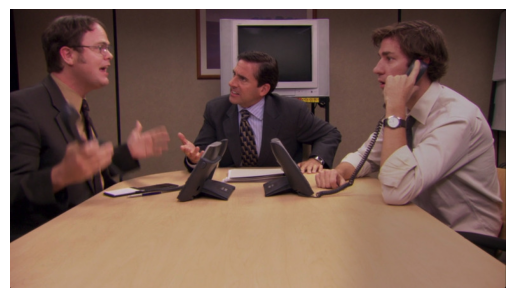

In [9]:
# load an input image

image_url = "https://www.looper.com/img/gallery/the-office-funniest-moments-ranked/jim-and-dwights-customer-service-training-1627594561.jpg"
# image_url = "https://ew.com/thmb/n5b8Asz4Y5Lp0sSEF7WgS-ESyFc=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/succession-finale-052923-ec304aabcbf24a7b9fad891a87f49b74.jpg"
# image_url = "https://i.kym-cdn.com/entries/icons/original/000/045/575/blackcatzoningout_meme.jpg"

try:
    response = requests.get(image_url, stream=True)
    response.raise_for_status()

    image = Image.open(BytesIO(response.content))
    width, height = image.size

    plt.imshow(image)
    plt.axis('off')
    plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

In [10]:
# detect faces
resp = RetinaFace.detect_faces(np.array(image))
print(resp)
bboxes = [resp[key]['facial_area'] for key in resp.keys()]
print(bboxes)

2026-01-19 03:26:50.472446: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1768793210.474051 1441763 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20972 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2026-01-19 03:26:50.474797: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1768793210.476485 1441763 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10825 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:24:00.0, compute capability: 8.9
2026-01-19 03:26:50.476887: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overri

{'face_1': {'score': np.float64(0.9995866417884827), 'facial_area': [np.int64(343), np.int64(80), np.int64(393), np.int64(148)], 'landmarks': {'right_eye': [np.float32(351.5381), np.float32(104.45727)], 'left_eye': [np.float32(364.24796), np.float32(109.84151)], 'nose': [np.float32(345.34286), np.float32(118.26313)], 'mouth_right': [np.float32(349.05844), np.float32(129.60323)], 'mouth_left': [np.float32(358.86572), np.float32(133.21237)]}}, 'face_2': {'score': np.float64(0.9990673661231995), 'facial_area': [np.int64(102), np.int64(28), np.int64(161), np.int64(119)], 'landmarks': {'right_eye': [np.float32(141.36922), np.float32(60.721626)], 'left_eye': [np.float32(151.71457), np.float32(62.110947)], 'nose': [np.float32(160.81157), np.float32(76.46389)], 'mouth_right': [np.float32(140.19006), np.float32(93.66121)], 'mouth_left': [np.float32(149.58084), np.float32(95.37316)]}}, 'face_3': {'score': np.float64(0.9970617890357971), 'facial_area': [np.int64(574), np.int64(44), np.int64(633),

In [11]:
# prepare gazelle input
img_tensor = transform(image).unsqueeze(0).to(device)
norm_bboxes = [[np.array(bbox) / np.array([width, height, width, height]) for bbox in bboxes]]

input = {
    "images": img_tensor, # [num_images, 3, 448, 448]
    "bboxes": norm_bboxes # [[img1_bbox1, img1_bbox2...], [img2_bbox1, img2_bbox2]...]
}

with torch.no_grad():
    # output = model(input)
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        output = model(input)

img1_person1_heatmap = output['heatmap'][0][0] # [64, 64] heatmap
print(img1_person1_heatmap.shape)
if model.inout:
  img1_person1_inout = output['inout'][0][0] # gaze in frame score (if model supports inout prediction)
  print(img1_person1_inout.item())


torch.Size([64, 64])
0.994140625


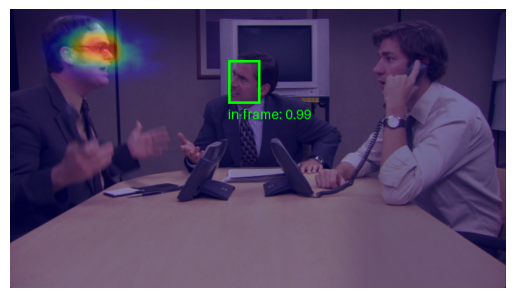

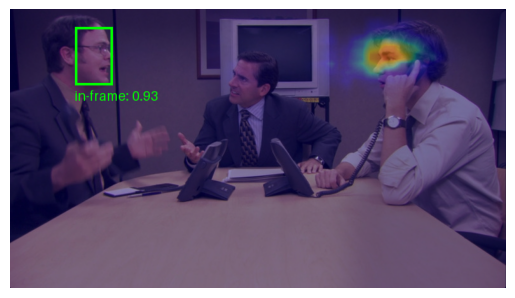

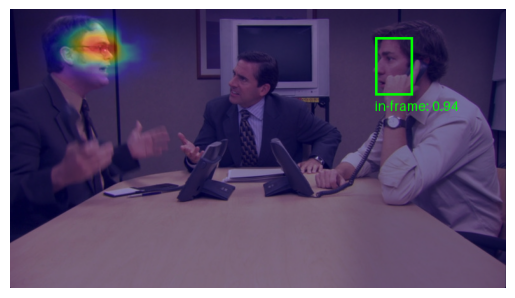

In [7]:
# visualize predicted gaze heatmap for each person and gaze in/out of frame score

def visualize_heatmap(pil_image, heatmap, bbox=None, inout_score=None):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(pil_image.size, Image.Resampling.BILINEAR)
    heatmap = plt.cm.jet(np.array(heatmap) / 255.)
    heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)
    heatmap = Image.fromarray(heatmap).convert("RGBA")
    heatmap.putalpha(90)
    overlay_image = Image.alpha_composite(pil_image.convert("RGBA"), heatmap)

    if bbox is not None:
        width, height = pil_image.size
        xmin, ymin, xmax, ymax = bbox
        draw = ImageDraw.Draw(overlay_image)
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline="lime", width=int(min(width, height) * 0.01))

        if inout_score is not None:
          text = f"in-frame: {inout_score:.2f}"
          text_width = draw.textlength(text)
          text_height = int(height * 0.01)
          text_x = xmin * width
          text_y = ymax * height + text_height
          draw.text((text_x, text_y), text, fill="lime", font=ImageFont.load_default(size=int(min(width, height) * 0.05)))
    return overlay_image

for i in range(len(bboxes)):
  plt.figure()
  plt.imshow(visualize_heatmap(image, output['heatmap'][0][i], norm_bboxes[0][i], inout_score=output['inout'][0][i] if output['inout'] is not None else None))
  plt.axis('off')
  plt.show()



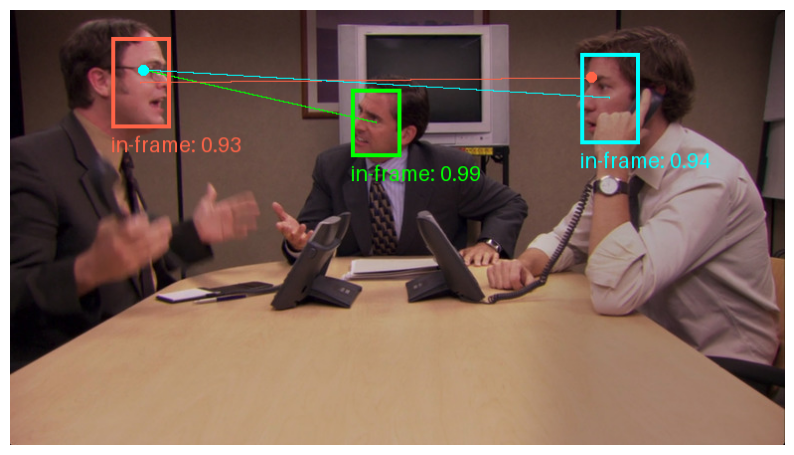

In [12]:
# combined visualization with maximal gaze points for each person

def visualize_all(pil_image, heatmaps, bboxes, inout_scores, inout_thresh=0.5):
    colors = ['lime', 'tomato', 'cyan', 'fuchsia', 'yellow']
    overlay_image = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(overlay_image)
    width, height = pil_image.size

    for i in range(len(bboxes)):
        bbox = bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        color = colors[i % len(colors)]
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline=color, width=int(min(width, height) * 0.01))

        if inout_scores is not None:
            inout_score = inout_scores[i]
            text = f"in-frame: {inout_score:.2f}"
            text_width = draw.textlength(text)
            text_height = int(height * 0.01)
            text_x = xmin * width
            text_y = ymax * height + text_height
            draw.text((text_x, text_y), text, fill=color, font=ImageFont.load_default(size=int(min(width, height) * 0.05)))

        if inout_scores is not None and inout_score > inout_thresh:
            heatmap = heatmaps[i]
            heatmap_np = heatmap.detach().cpu().numpy()
            max_index = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)
            gaze_target_x = max_index[1] / heatmap_np.shape[1] * width
            gaze_target_y = max_index[0] / heatmap_np.shape[0] * height
            bbox_center_x = ((xmin + xmax) / 2) * width
            bbox_center_y = ((ymin + ymax) / 2) * height

            draw.ellipse([(gaze_target_x-5, gaze_target_y-5), (gaze_target_x+5, gaze_target_y+5)], fill=color, width=int(0.005*min(width, height)))
            draw.line([(bbox_center_x, bbox_center_y), (gaze_target_x, gaze_target_y)], fill=color, width=int(0.005*min(width, height)))

    return overlay_image

plt.figure(figsize=(10,10))
plt.imshow(visualize_all(image, output['heatmap'][0], norm_bboxes[0], output['inout'][0] if output['inout'] is not None else None, inout_thresh=0.5))
plt.axis('off')
plt.show()

## 视频处理：从视频输入并保存带注视点的输出视频

In [25]:
import cv2
from pathlib import Path

def process_video_with_gaze(video_path, output_path, model, transform, device, inout_thresh=0.5):
    """
    处理视频，检测人脸并绘制注视热力图
    
    Args:
        video_path: 输入视频路径
        output_path: 输出视频路径
        model: GazeLLE 模型
        transform: 图像转换
        device: 计算设备
        inout_thresh: 注视在框内的阈值
    """
    # 打开视频
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"无法打开视频: {video_path}")
        return
    
    # 获取视频信息
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"视频信息: {width}x{height}, {fps} FPS, 总帧数: {total_frames}")
    
    # 设置视频编码和写入器
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame_count += 1
        
        # 转换 BGR 到 RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_frame)
        
        # 检测人脸
        try:
            resp = RetinaFace.detect_faces(rgb_frame)
            if isinstance(resp, dict) and len(resp) > 0:
                bboxes = [resp[key]['facial_area'] for key in resp.keys() if key != 'det']
                
                if len(bboxes) > 0:
                    # 准备模型输入
                    img_tensor = transform(pil_image).unsqueeze(0).to(device)
                    norm_bboxes = [[np.array(bbox) / np.array([width, height, width, height]) for bbox in bboxes]]
                    
                    model_input = {
                        "images": img_tensor,
                        "bboxes": norm_bboxes
                    }
                    
                    # 模型推理
                    with torch.no_grad():
                        output = model(model_input)
                    
                    # 绘制注视热力图
                    frame_with_gaze = visualize_all(
                        pil_image, 
                        output['heatmap'][0], 
                        norm_bboxes[0], 
                        output['inout'][0] if output['inout'] is not None else None,
                        inout_thresh=inout_thresh
                    )
                    
                    # 转换回 cv2 格式
                    frame_with_gaze = cv2.cvtColor(np.array(frame_with_gaze.convert('RGB')), cv2.COLOR_RGB2BGR)
                else:
                    frame_with_gaze = frame
            else:
                frame_with_gaze = frame
        except Exception as e:
            print(f"帧 {frame_count} 处理出错: {e}")
            frame_with_gaze = frame
        
        # 写入输出视频
        out.write(frame_with_gaze)
        
        if frame_count % 30 == 0:
            print(f"已处理 {frame_count}/{total_frames} 帧")
    
    cap.release()
    out.release()
    print(f"视频处理完成! 保存到: {output_path}")


# video_input_path = "/projects/kzh/gazelle/test_videos/video_24.mp4"  # 完整路径
video_input_path = "test_videos/video_105.mp4"
video_output_path = "output_gazelle/video_105.mp4"

# 如果你有本地视频文件，可以直接运行
process_video_with_gaze(video_input_path, video_output_path, model, transform, device)

视频信息: 1920x1080, 23 FPS, 总帧数: 92
已处理 30/92 帧
已处理 30/92 帧
已处理 60/92 帧
已处理 60/92 帧
已处理 90/92 帧
已处理 90/92 帧
视频处理完成! 保存到: output_gazelle/video_105.mp4
视频处理完成! 保存到: output_gazelle/video_105.mp4


In [15]:
# 使用示例：处理视频
# 这里假设你有一个视频文件，或者可以从网上下载一个小视频进行测试

# 选项 1: 如果你有本地视频文件
video_input = "/test_videos/video_12.mp4"
video_output = "/output_gazelle/video_12.mp4"

# 检查视频文件是否存在
if Path(video_input).exists():
    print(f"开始处理视频: {video_input}")
    process_video_with_gaze(video_input, video_output, model, transform, device, inout_thresh=0.5)
else:
    print(f"视频文件不存在: {video_input}")
    print(f"请提供一个有效的视频文件路径")
    print(f"\n使用方法:")
    print(f"1. 将你的视频文件放在指定路径")
    print(f"2. 修改 video_input 变量为你的视频路径")
    print(f"3. 运行此单元格进行处理")

视频文件不存在: /test_videos/video_12.mp4
请提供一个有效的视频文件路径

使用方法:
1. 将你的视频文件放在指定路径
2. 修改 video_input 变量为你的视频路径
3. 运行此单元格进行处理


## 快速参考

### 功能说明

1. **`process_video_with_gaze()`** - 主要处理函数
   - 逐帧读取视频
   - 对每一帧进行人脸检测
   - 使用 Gazelle 模型预测注视热力图
   - 在视频上绘制注视点和概率标签
   - 保存输出视频

2. **`download_video_from_url()`** - 视频下载函数
   - 从 URL 下载视频文件

### 输出特性

输出视频中包含：
- 🟢 绿色边框：人脸检测框
- 🟢 热力图覆盖层：注视区域热力图（彩色表示）
- 🟢 概率值：右上角显示"in-frame"概率
- 🟢 注视点箭头：当概率 > 阈值时，从人脸中心指向注视点

### 参数说明

- `inout_thresh`: 0.0-1.0，决定是否绘制注视箭头的阈值
  - 设置为 0.5 表示只有当"in-frame"概率 > 0.5 时才绘制箭头

### 输出格式

- 编码: MP4 (mp4v)
- 分辨率: 与输入视频相同
- 帧率: 与输入视频相同